In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
# 1. Environment Setup
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, 
                             roc_auc_score, 
                             confusion_matrix,
                             precision_recall_curve)
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 2. Data Loading & Validation
# ======================
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Initial dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Initial dataset shape: (7043, 21)

First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# 3. Data Cleaning
# ======================
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values
print("\nMissing values before cleaning:")
print(df.isna().sum())

# Remove rows with missing TotalCharges
df = df.dropna(subset=['TotalCharges'])

# Convert SeniorCitizen to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Create target variable
df['DefaultRisk'] = np.where((df['Churn'] == 'Yes') & 
                           (df['PaymentMethod'].isin(['Electronic check', 'Mailed check'])), 1, 0)


Missing values before cleaning:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [5]:
# Remove unnecessary columns
df = df.drop(['customerID', 'Churn'], axis=1)

In [6]:
# Handle outliers in MonthlyCharges

Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

df = df[
    ~(  # Tilde operator for inverse selection
        (df['MonthlyCharges'] < (Q1 - 1.5 * IQR)) | 
        (df['MonthlyCharges'] > (Q3 + 1.5 * IQR))
    )
]

print(f"Data after outlier removal: {df.shape}")

Data after outlier removal: (7032, 20)



Descriptive Statistics:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DefaultRisk
count,7032,7032,7032,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032.000000
unique,2,2,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,NaN
top,Male,No,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN
freq,3549,5890,3639,4933,NaN,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,32.421786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441,0.196104
std,NaN,NaN,NaN,NaN,24.545260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362,0.397076
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,0.000000
25%,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000,0.000000
50%,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,0.000000
75%,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3794.737500,0.000000



Data Types:
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
DefaultRisk           int64
dtype: object

Missing Values After Cleaning:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Monthly

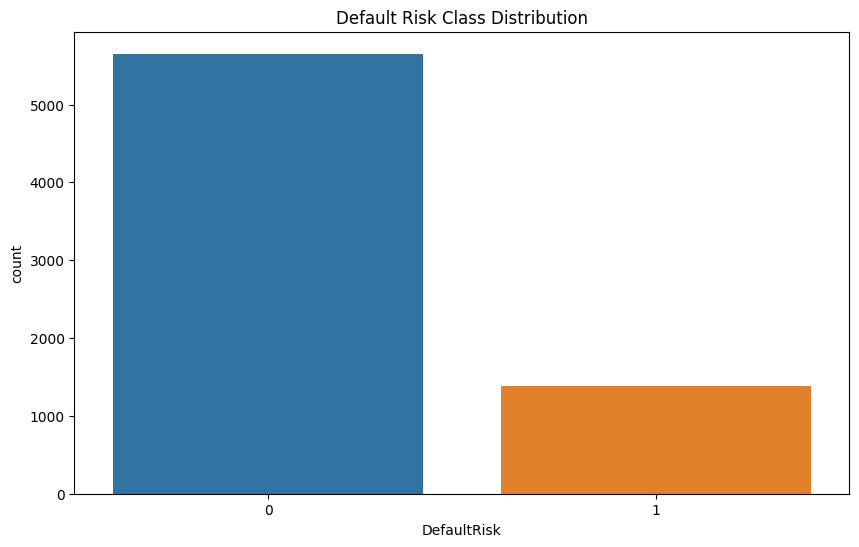

In [7]:
# 4. Comprehensive Manual EDA
# ======================
# Generate descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe(include='all'))

# Data type analysis
print("\nData Types:")
print(df.dtypes)

# Missing values check
print("\nMissing Values After Cleaning:")
print(df.isna().sum())

# Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='DefaultRisk', data=df)
plt.title('Default Risk Class Distribution')
plt.show()

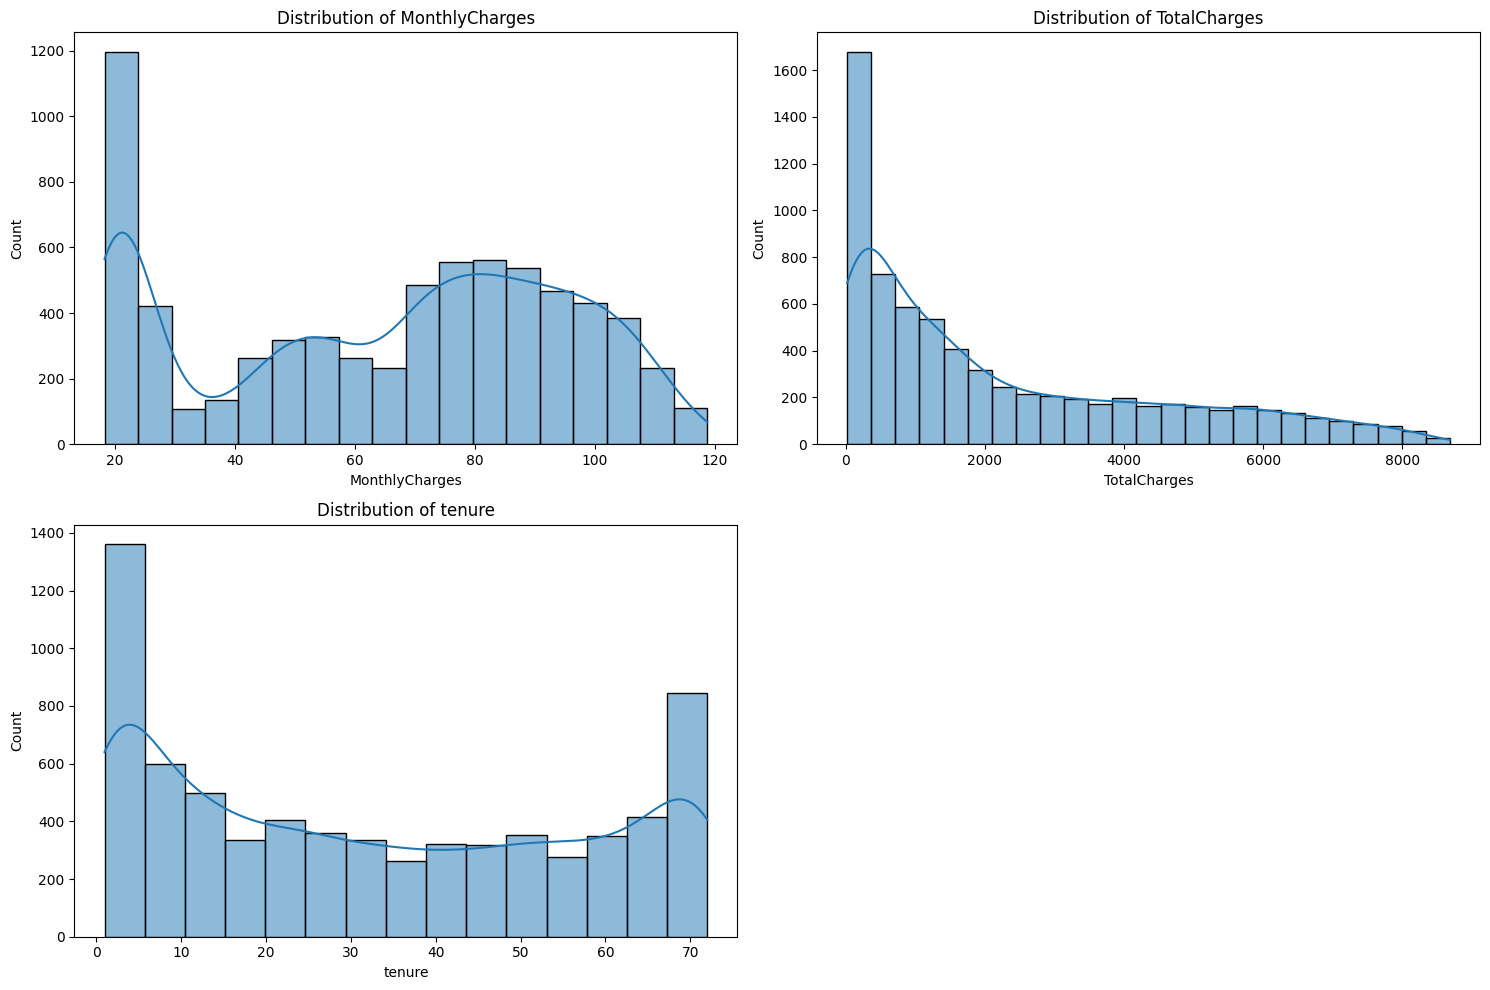

In [8]:
# Numerical features analysis
num_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

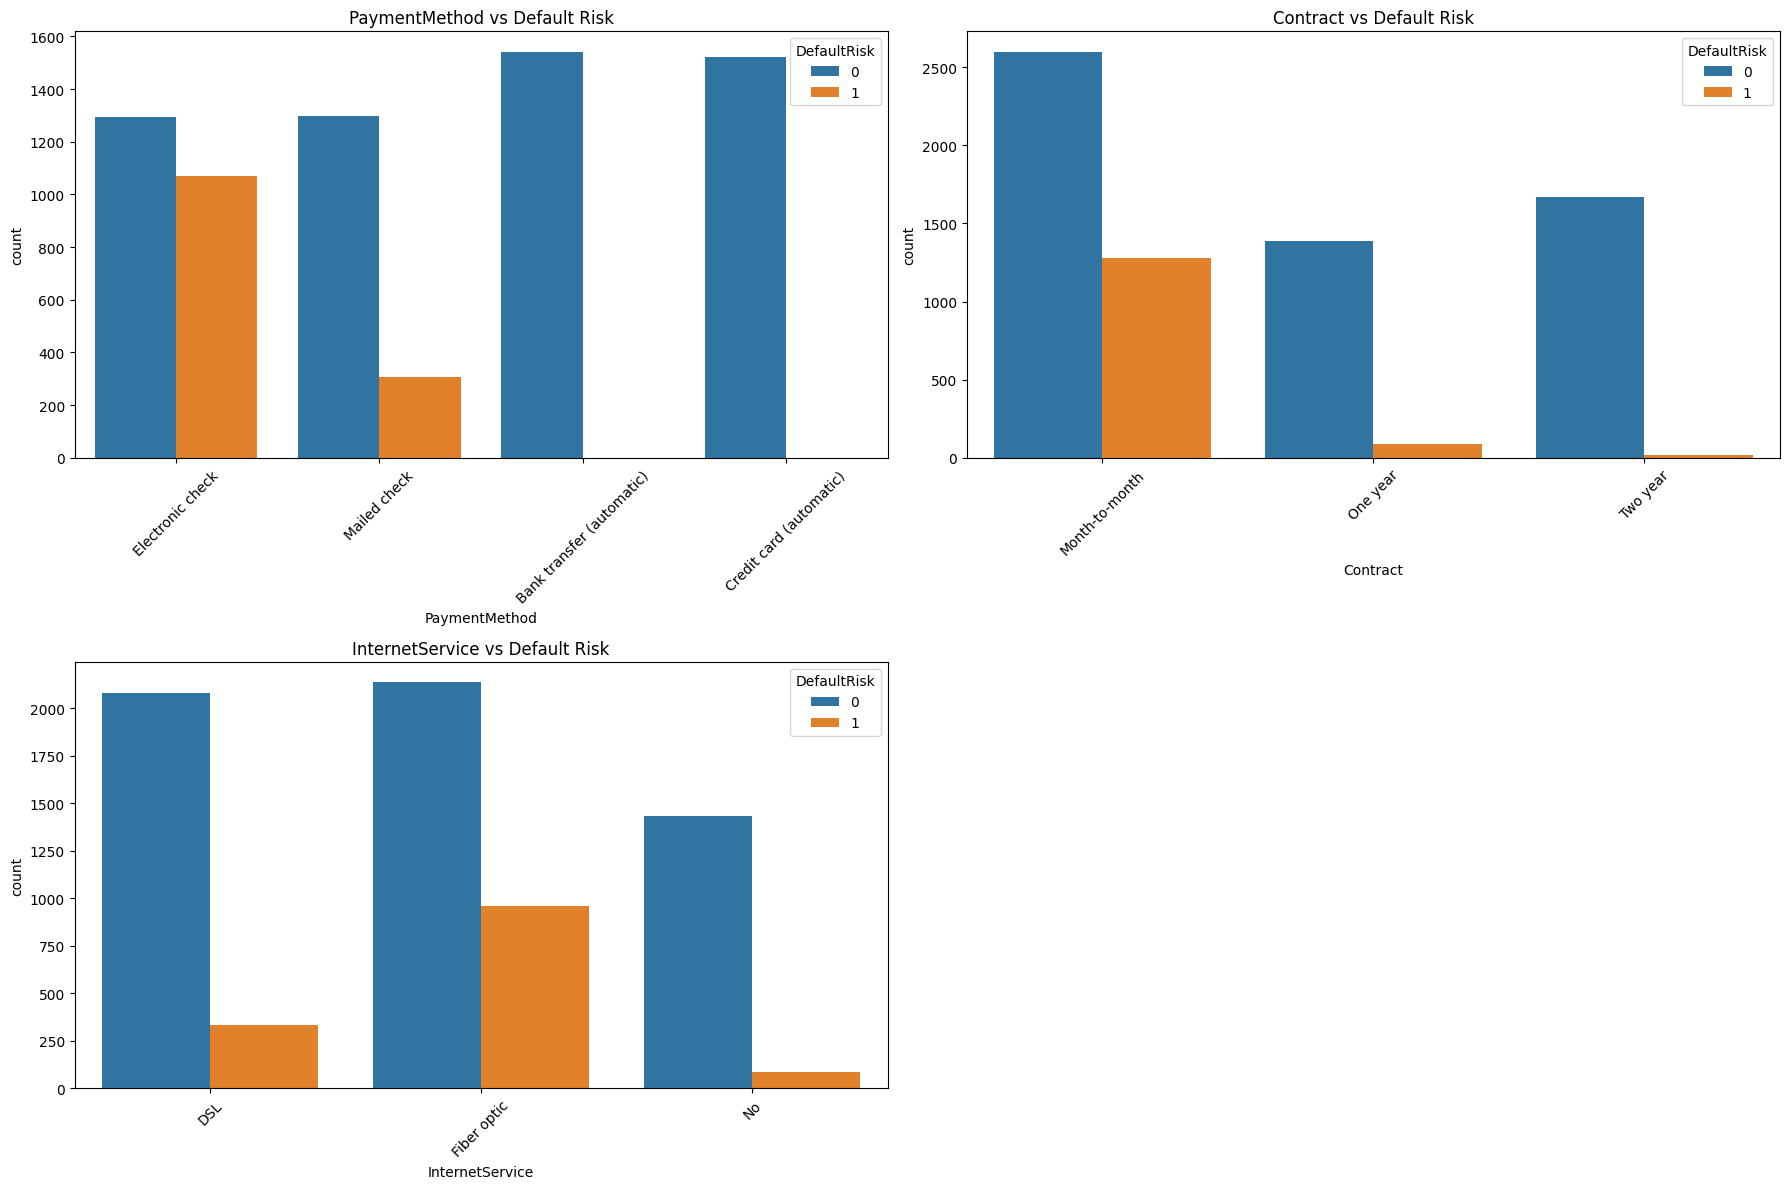

In [9]:
# Categorical features analysis
cat_cols = ['PaymentMethod', 'Contract', 'InternetService']
plt.figure(figsize=(18, 12))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='DefaultRisk', data=df)
    plt.title(f'{col} vs Default Risk')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

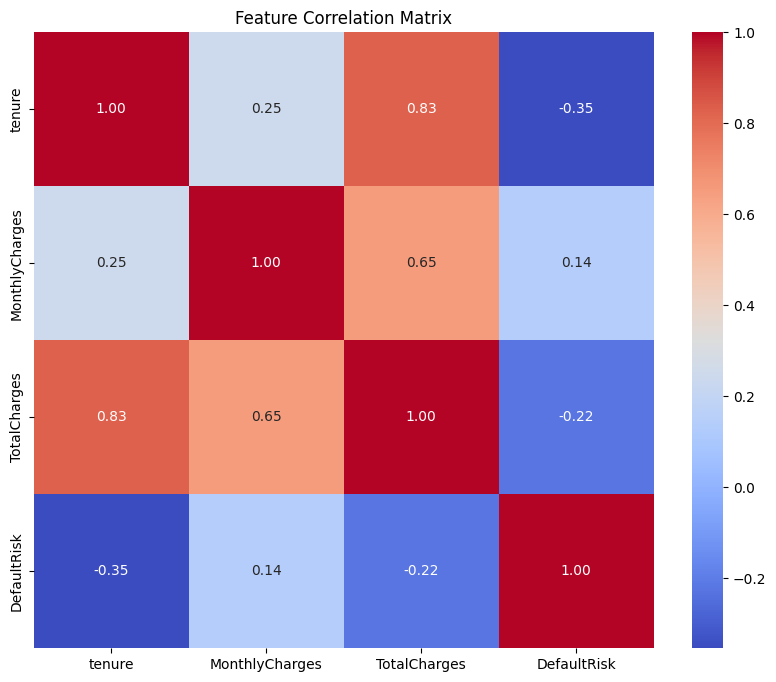

In [10]:
# Correlation analysis
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [11]:
# Payment method analysis
payment_analysis = df.groupby('PaymentMethod')['DefaultRisk'].agg(['mean', 'count'])
print("\nPayment Method Risk Analysis:")
display(payment_analysis)


Payment Method Risk Analysis:


,mean,count
PaymentMethod,,
Bank transfer (automatic),0.000000,1542
Credit card (automatic),0.000000,1521
Electronic check,0.452854,2365
Mailed check,0.192020,1604


In [12]:
# 5. Feature Engineering
# ======================
# Create new features
df['Monthly_to_Total_Ratio'] = df['MonthlyCharges'] / df['TotalCharges']
df['Tenure_Group'] = pd.cut(df['tenure'], 
                           bins=[0, 12, 24, 60], 
                           labels=['New', 'Established', 'Long-term'])
df['Tenure_Months'] = df['tenure']
df = df.drop(['tenure', 'TotalCharges'], axis=1)


In [13]:
# 6. Preprocessing
# ======================
# Define features and target
X = df.drop('DefaultRisk', axis=1)
y = df['DefaultRisk']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
# Define preprocessing
numeric_features = ['MonthlyCharges', 'Tenure_Months', 'Monthly_to_Total_Ratio']
categorical_features = ['PaymentMethod', 'Contract', 'InternetService', 'Tenure_Group']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [15]:
# 7. Model Training
# ======================
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        random_state=42))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'Tenure_Months',
                                                   'Monthly_to_Total_Ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PaymentMethod', 'Contract',
                                                   'InternetService',
                                                   'Tenure_Group'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                                            n_estimators=200, random_state=42,
                                            subsample=0.8))])

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1131
           1       0.66      0.56      0.61       276

    accuracy                           0.86      1407
   macro avg       0.78      0.75      0.76      1407
weighted avg       0.85      0.86      0.85      1407


ROC AUC Score: 0.92


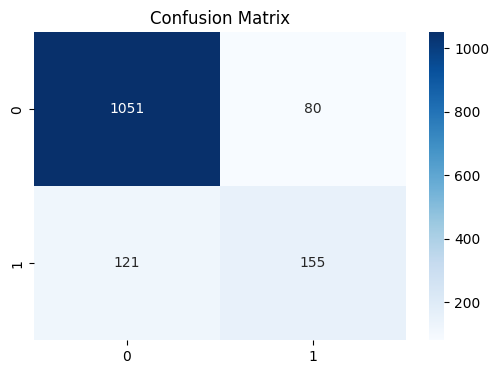

In [16]:
# 8. Model Evaluation
# ======================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# 9. Business Impact
# ======================
# Create risk segments
test_df = X_test.copy()
test_df['Default_Probability'] = y_proba
test_df['Risk_Segment'] = pd.qcut(y_proba, q=3, 
                                labels=['Low', 'Medium', 'High'])

In [18]:
# Calculate financial impact
risk_summary = test_df.groupby('Risk_Segment').agg(
    Total_Customers=('Risk_Segment', 'count'),
    Average_Probability=('Default_Probability', 'mean'),
    Total_MRR=('MonthlyCharges', 'sum')
).reset_index()

risk_summary['At_Risk_MRR'] = risk_summary['Total_MRR'] * risk_summary['Average_Probability']
print("\nFinancial Impact Analysis:")
display(risk_summary)



Financial Impact Analysis:


,Risk_Segment,Total_Customers,Average_Probability,Total_MRR,At_Risk_MRR
0,Low,469,0.003303,30687.85,101.365756
1,Medium,469,0.050815,24367.30,1238.225950
2,High,469,0.515239,33981.90,17508.805543


In [19]:
# 10. Action Recommendations
# ======================
print("\nRecommended Actions:")
print("""
High Risk (Probability > 0.65):
- Personal phone call from account manager
- Alternative payment plan offers
- Temporary service downgrade options

Medium Risk (0.35 < Probability <= 0.65):
- Automated payment reminders
- Payment method update incentives
- Service usage check-ins

Low Risk (Probability <= 0.35):
- Annual payment discount offers
- Loyalty program enrollment
- Upsell opportunities
""")


Recommended Actions:

High Risk (Probability > 0.65):
- Personal phone call from account manager
- Alternative payment plan offers
- Temporary service downgrade options

Medium Risk (0.35 < Probability <= 0.65):
- Automated payment reminders
- Payment method update incentives
- Service usage check-ins

Low Risk (Probability <= 0.35):
- Annual payment discount offers
- Loyalty program enrollment
- Upsell opportunities

